# IBM Data Sciene Capstone
This notebook is for the Capstone project

In [4]:
import pandas as pd
import numpy as np
import json
import requests
from bs4 import BeautifulSoup

# First Part: scraping

In [46]:
df = pd.DataFrame(columns = ['PostalCode','Borough','Neighborhood'])

url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
soup = BeautifulSoup(source, 'xml')
table = soup.find('table')

for row in table.find_all('tr'):
    row_list = []
    for cell in row.find_all('td'):
        row_list.append(cell.text.strip())
    if len(row_list)==3 and row_list[1] != 'Not assigned':
        if row_list[2] == 'Not assigned':
            row_list[2] = row_list[1]
        df.loc[len(df)] = row_list

In [47]:
print(df.shape)
df.head(10)

(103, 3)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


# Second Part: adding geospatial data

In [48]:
df_geo = pd.read_csv('Geospatial_Coordinates.csv').rename(columns={'Postal Code': 'PostalCode'})
df_geo

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476
...,...,...,...
98,M9N,43.706876,-79.518188
99,M9P,43.696319,-79.532242
100,M9R,43.688905,-79.554724
101,M9V,43.739416,-79.588437


In [49]:
df = df.merge(df_geo, on='PostalCode', how='left', copy=False)
df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.667856,-79.532242
6,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
7,M3B,North York,Don Mills,43.745906,-79.352188
8,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937


# Third Part: exploring and clustering

Selecting only Toronto for the dataset

In [50]:
data = df[df['Borough'].str.contains("Toronto")]
data.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
19,M4E,East Toronto,The Beaches,43.676357,-79.293031
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


In [56]:
CLIENT_ID = 'IMIYZAVIBA3W3VMNRQ11B1BAA0PL1P11H1HXF35TK4TEUFP3' # your Foursquare ID
CLIENT_SECRET = 'PPIJDHQCDRLXEKJOVJSGYSS0JELGWVKTMJL2RF1V0SDHUX3M' # your Foursquare Secret
VERSION = '20200116'

Create a map and locate the markers

In [43]:
import json

!pip3 install geopy
from geopy.geocoders import Nominatim

import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

!pip3 install folium
import folium 


     |████████████████████████████████| 112 kB 836 kB/s 
     |████████████████████████████████| 94 kB 792 kB/s 


In [45]:
address = 'Toronto'

geolocator = Nominatim(user_agent="capstone")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coords Toronto {}, {}.'.format(latitude, longitude))

Coords Toronto 43.6534817, -79.3839347.


In [52]:
# create map
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to the map
for index, row in df.iterrows():
    label = f'{row.Neighborhood}, {row.Borough}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row.Latitude, row.Longitude],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Search for the nearby venues and analize them

In [59]:
def getNearbyVenues(names, latitudes, longitudes):
    radius=500
    LIMIT=100
    venues_list=[]
    for name, lat, lon in zip(names, latitudes, longitudes):
            
        url = f'https://api.foursquare.com/v2/venues/explore?&client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lon}&radius={radius}&limit={LIMIT}'

        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
            name, 
            lat, 
            lon, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return nearby_venues

In [61]:
to_venues = getNearbyVenues(data['Neighborhood'], data['Latitude'], data['Longitude'])

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
The Beaches
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
The Danforth West, Riverdale
Toronto Dominion Centre, Design Exchange
Brockton, Parkdale Village, Exhibition Place
India Bazaar, The Beaches West
Commerce Court, Victoria Hotel
Studio District
Lawrence Park
Roselawn
Davisville North
Forest Hill North & West, Forest Hill Road Park
High Park, The Junction South
North Toronto West,  Lawrence Park
The Annex, North Midtown, Yorkville
Parkdale, Roncesvalles
Davisville
University of Toronto, Harbord
Runnymede, Swansea
Moore Park, Summerhill East
Kensington Market, Chinatown, Grange Park
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport


In [62]:
to_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [67]:
# one hot encoding
to_onehot = pd.get_dummies(to_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhood'] = to_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

to_onehot.head()

,Yoga Studio,Airport,Airport Food Court,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,...,Theme Restaurant,Tibetan Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [72]:
to_grouped = to_onehot.groupby('Neighborhood').mean().reset_index()
num_top_venues = 5

for hood in to_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = manhattan_grouped[to_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Berczy Park----
                venue  freq
0         Coffee Shop  0.10
1        Cocktail Bar  0.05
2            Beer Bar  0.03
3  Seafood Restaurant  0.03
4         Cheese Shop  0.03


----Brockton, Parkdale Village, Exhibition Place----
            venue  freq
0            Café  0.13
1  Breakfast Spot  0.09
2          Bakery  0.09
3     Coffee Shop  0.09
4       Nightclub  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                  venue  freq
0           Yoga Studio  0.06
1                   Spa  0.06
2  Gym / Fitness Center  0.06
3         Garden Center  0.06
4                Garden  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
                venue  freq
0     Airport Service  0.21
1      Airport Lounge  0.14
2    Airport Terminal  0.14
3     Harbor / Marina  0.07
4  Airport Food Court  0.07


----Central Bay Street----
                venue  f

In [73]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [124]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = to_grouped['Neighborhood']

for ind in np.arange(to_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(to_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Restaurant,Farmers Market,Beer Bar,Seafood Restaurant,Greek Restaurant,Juice Bar
1,"Brockton, Parkdale Village, Exhibition Place",Café,Coffee Shop,Breakfast Spot,Bakery,Performing Arts Venue,Restaurant,Italian Restaurant,Stadium,Intersection,Bar
2,"Business reply mail Processing Centre, South C...",Yoga Studio,Garden,Skate Park,Light Rail Station,Burrito Place,Spa,Farmers Market,Fast Food Restaurant,Restaurant,Recording Studio
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Harbor / Marina,Coffee Shop,Boat or Ferry,Sculpture Garden,Airport Food Court,Airport,Rental Car Location
4,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Middle Eastern Restaurant,Burger Joint,Salad Place,Bubble Tea Shop,Miscellaneous Shop,Furniture / Home Store
5,Christie,Grocery Store,Café,Park,Coffee Shop,Baby Store,Italian Restaurant,Athletics & Sports,Restaurant,Candy Store,Nightclub
6,Church and Wellesley,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Restaurant,Fast Food Restaurant,Gay Bar,Yoga Studio,Men's Store,Pub,Hotel
7,"Commerce Court, Victoria Hotel",Coffee Shop,Restaurant,Hotel,Café,American Restaurant,Gym,Seafood Restaurant,Deli / Bodega,Italian Restaurant,Japanese Restaurant
8,Davisville,Pizza Place,Sandwich Place,Dessert Shop,Sushi Restaurant,Gym,Italian Restaurant,Coffee Shop,Café,Pharmacy,Brewery
9,Davisville North,Gym / Fitness Center,Hotel,Department Store,Sandwich Place,Breakfast Spot,Food & Drink Shop,Park,General Travel,Ethiopian Restaurant,Electronics Store


#### Clustering

Selecting number of clusters

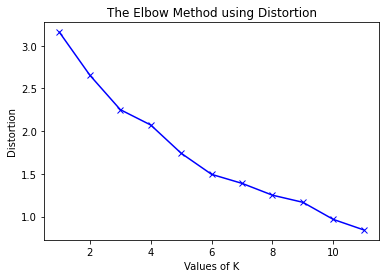

In [109]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist 


distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 

for i in range(1, 12):
    kmeanModel = KMeans(n_clusters=i, random_state=0).fit(to_grouped_clustering)
      
    distortions.append(sum(np.min(cdist(to_grouped_clustering, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / to_grouped_clustering.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[i] = sum(np.min(cdist(to_grouped_clustering, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / to_grouped_clustering.shape[0] 
    mapping2[i] = kmeanModel.inertia_ 

plt.plot(range(1,12), inertias, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show() 

Clustering with n=6

In [125]:
# set number of clusters
n = 7

to_grouped_clustering = to_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=n, random_state=0).fit(to_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 0, 0, 6, 6, 0, 6, 6, 0, 6], dtype=int32)

In [126]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

to_merged = data

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each neighborhood
to_merged = to_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

to_merged.head(10) # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,6,Coffee Shop,Pub,Bakery,Park,Café,Restaurant,Breakfast Spot,Theater,Wine Shop,French Restaurant
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,6,Coffee Shop,Sushi Restaurant,Yoga Studio,Creperie,Sandwich Place,Burrito Place,Café,Portuguese Restaurant,Park,College Cafeteria
9,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,6,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Bubble Tea Shop,Hotel,Middle Eastern Restaurant,Japanese Restaurant,Diner,Ramen Restaurant
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,6,Coffee Shop,Café,American Restaurant,Cocktail Bar,Gastropub,Hotel,Gym,Cosmetics Shop,Department Store,Moroccan Restaurant
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Health Food Store,Trail,Pub,Wine Shop,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Eastern European Restaurant
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,6,Coffee Shop,Cocktail Bar,Bakery,Cheese Shop,Restaurant,Farmers Market,Beer Bar,Seafood Restaurant,Greek Restaurant,Juice Bar
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,6,Coffee Shop,Café,Italian Restaurant,Sandwich Place,Middle Eastern Restaurant,Burger Joint,Salad Place,Bubble Tea Shop,Miscellaneous Shop,Furniture / Home Store
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,0,Grocery Store,Café,Park,Coffee Shop,Baby Store,Italian Restaurant,Athletics & Sports,Restaurant,Candy Store,Nightclub
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,6,Coffee Shop,Café,Restaurant,Clothing Store,Deli / Bodega,Gym,Hotel,Thai Restaurant,Bookstore,Steakhouse
31,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,0,Bakery,Pharmacy,Pet Store,Furniture / Home Store,Middle Eastern Restaurant,Music Venue,Park,Coffee Shop,Pool,Café


In [127]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(n)
ys = [i + x + (i*x)**2 for i in range(n)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Latitude'], to_merged['Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters